### Step 1：图像读取与骨骼化

- 不明显的线头（定义：端点在y和x轴方向与主干连线上的像素均为前景）会被忽略（不会形成骨骼化分支）

<div align="center">
<img src='image.png' width='20%'/>
</div>

- 使用`cv2.ximgproc.thinning`方法需要`pip install opencv-contrib-python`

- 已测试了包括`from skimage.morphology import skeletonize`在内的多种骨骼化方法，`cv2.ximgproc.thinning`的`Zhang-Suen`方法效果最好

In [2]:
import fitz
from PIL import Image
import cv2
import numpy as np
doc = fitz.open("./5.pdf")
page = doc[0]
pix = page.get_pixmap(dpi=300)
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
print(img_cv.shape)

# 二值化图像，前景为白（原图前景为黑则使用 THRESH_BINARY_INV）
thresh = cv2.threshold(img_cv, 127, 255, cv2.THRESH_BINARY_INV)[1]

# 使用OpenCV的细化算法获得骨架
thinned = cv2.ximgproc.thinning(thresh)

# 将骨架图转为二值（0/1）格式
thinned_bin = (thinned == 255).astype(np.uint8)
print(thinned_bin.shape)

(8534, 8534)
(8534, 8534)


In [19]:
from PIL import Image

# 保存thinned_bin为jpg
Image.fromarray(thinned_bin * 255).save('thinned_bin.jpg')

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # 设置图像索引
# pic_index = 9

# # 读取图像（保留alpha通道）
# image = cv2.imread(f'{pic_index}.jpg', cv2.IMREAD_UNCHANGED)
# print("Original shape:", image.shape)

# # 将图像转换为灰度图
# if len(image.shape) == 3:
#     # 如果是带透明通道的RGBA图像
#     if image.shape[2] == 4:
#         b, g, r, a = cv2.split(image)
#         # 创建白色背景
#         white_bg = np.ones_like(a, dtype=np.uint8) * 255
#         image_rgb = cv2.merge([b, g, r])
#         image_rgb[a == 0] = [255, 255, 255]
#         image = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
#     # 如果是RGB图像
#     elif image.shape[2] == 3:
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # 二值化图像，前景为白（原图前景为黑则使用 THRESH_BINARY_INV）
# thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)[1]
# print("Binary shape:", thresh.shape)

# # 使用OpenCV的细化算法获得骨架
# thinned = cv2.ximgproc.thinning(thresh)

# # 将骨架图转为二值（0/1）格式
# thinned_bin = (thinned == 255).astype(np.uint8)

Original shape: (4267, 4267, 3)
Binary shape: (4267, 4267)


### Step 2：获取候选线头

此步骤获取的候选线头大致可分为以下三个类别：

- T型线头：即为目标点

- V型线头：由V型轮廓得到的骨骼化结果

- l型线头：由较长线头得到的骨骼化结果

Check points: 1346


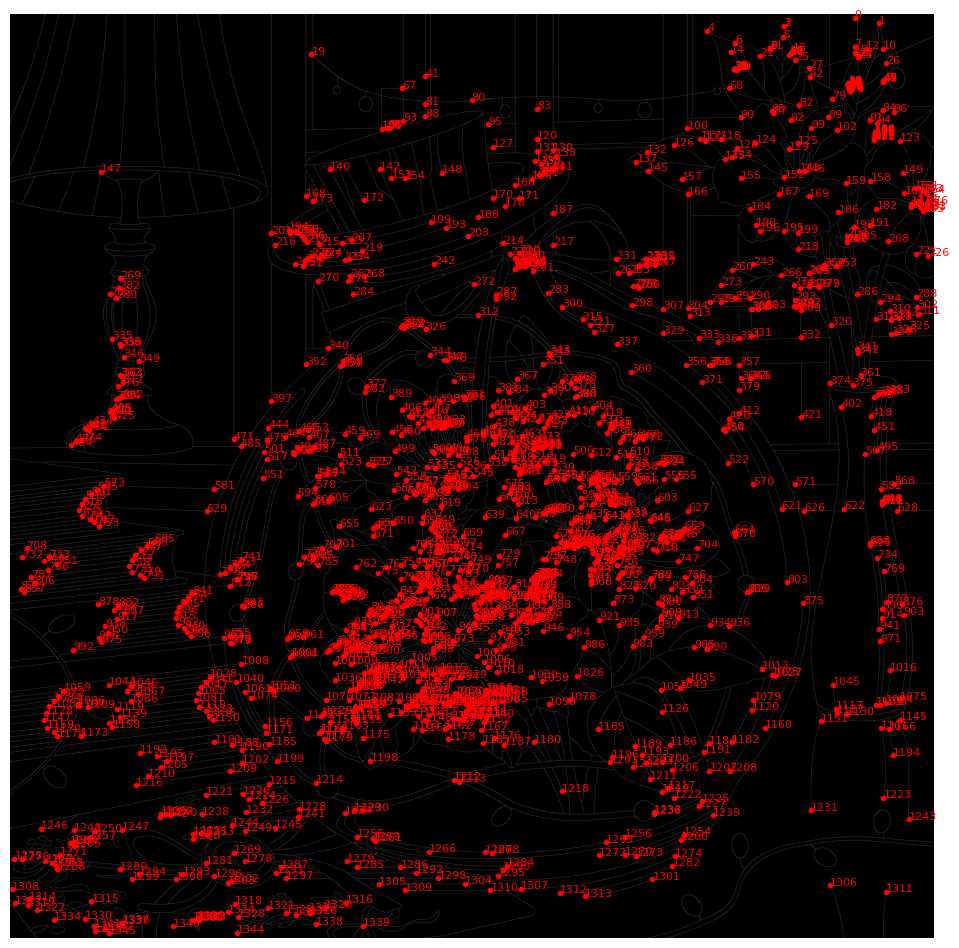

In [3]:
import matplotlib.pyplot as plt

# 定义一个卷积核，用于检测八邻域之和
kernel = np.array([[1, 1, 1],
                   [1, 10, 1],
                   [1, 1, 1]])

# 卷积操作，寻找中心点 + 八邻域 == 11 的点（即中心是1，邻域有1个值为1）
conv = cv2.filter2D(thinned_bin, -1, kernel, borderType=cv2.BORDER_CONSTANT)

# 找到候选点（值为11的点）
check_points = np.where(conv == 11)

# 去除图像边界一定宽度内的点，避免越界处理
board = 10
mask = (check_points[0] > board) & (check_points[0] < thinned_bin.shape[0] - board) & \
       (check_points[1] > board) & (check_points[1] < thinned_bin.shape[1] - board)
check_points = (check_points[0][mask], check_points[1][mask])
print("Check points:", len(check_points[0]))

# 可视化候选点
plt.figure(figsize=(12, 12))
plt.imshow(thinned_bin, cmap='gray')
for i, (y, x) in enumerate(zip(*check_points)):
    plt.plot(x, y, 'ro', markersize=3)
    plt.text(x, y, str(i), color='red', fontsize=8)
plt.axis('off')
plt.show()

### Step 3：定义 Zhang-Suen A(p) 计算函数

判断逻辑：

- A(p) = 1 → 端点（end point）

- A(p) = 2 → 连续点（line point）

- A(p) ≥ 3 → 分支点、交叉点（branch/cross point）

In [4]:
def get_Ap(binary_img, y, x):
    """
    Zhang-Suen 细化算法中 A(p) 值的计算：
    A(p) 表示从0到1的转变次数，用于检测是否为交叉点
    """
    if binary_img[y, x] == 0:
        return 0  # 背景点直接返回0

    # 取八邻域像素
    P2 = binary_img[y - 1, x]
    P3 = binary_img[y - 1, x + 1]
    P4 = binary_img[y, x + 1]
    P5 = binary_img[y + 1, x + 1]
    P6 = binary_img[y + 1, x]
    P7 = binary_img[y + 1, x - 1]
    P8 = binary_img[y, x - 1]
    P9 = binary_img[y - 1, x - 1]

    neighbors = [P2, P3, P4, P5, P6, P7, P8, P9, P2]  # 闭合环用于过渡计算
    transitions = 0
    for i in range(8):
        if neighbors[i] == 0 and neighbors[i + 1] == 1:
            transitions += 1
    return transitions


### Step 4：线头筛选

遍历所有候选线头，在局部ROI中判断：

1. 首先保留与线头连通的区域（排除无关点的影响）；

2. 获取ROI中的交叉点（定义：在八连通方向上大于等于三个点，不在ROI边缘，且满足邻域过渡次数 A(p)大于等于3次）；

    若没有检测到交叉点，则跳过；反之按照其与中心（线头点）的曼哈顿距离升序排序；

    若交叉点数量大于1，说明当前ROI较为复杂，若此时进行判断错误率较高，需要进一步裁剪（让次近点刚好落在新ROI边界的同时保证最近点不会落在边界）；

<div align="center">
<img src='image-1.png' width='20%'/>
</div>

3. 获取（新）ROI中的边缘点，按照连通性分组，每组取距离中心最远的端点；

    若边缘点数量小于1，则跳过；

    若边缘点数量大于2，则保留相对距离最远的一对边缘点；

4. 分别构建交叉点到中心点、边缘点的向量（分别记为v0、v1/v2），通过点乘计算余弦值，从而判断T/V；

    若v0处于v1、v2之间，则判定为T；

    若v1、v2的夹角小于150度，则判定为T，反之为V；

Final points: 129


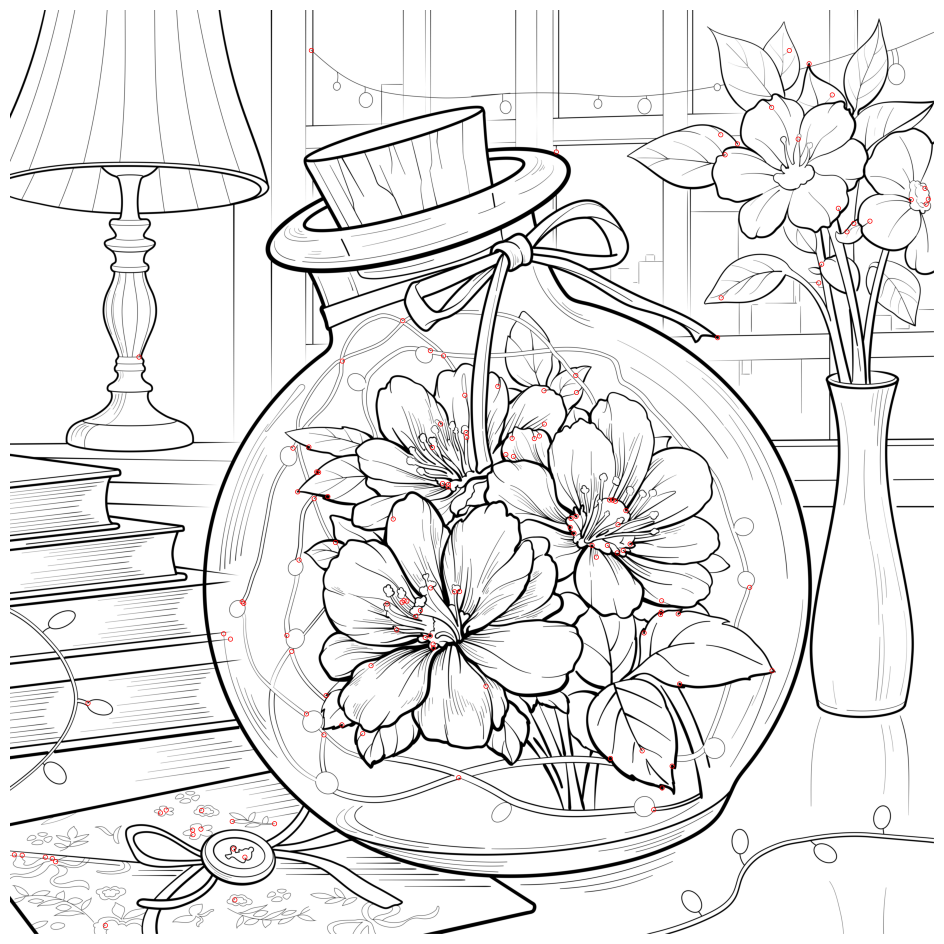

In [10]:
final_points = []

# 遍历所有候选点
for cy, cx in zip(*check_points):
    half_width = 80
    cropped = False  # 标记是否重新裁剪过区域

    while True:
        # 提取以候选点为中心的区域
        top = max(cy - half_width, 0)
        bottom = min(cy + half_width, thinned_bin.shape[0] - 1)
        left = max(cx - half_width, 0)
        right = min(cx + half_width, thinned_bin.shape[1] - 1)

        area = thinned_bin[top:bottom, left:right]
        center_y = cy - top
        center_x = cx - left

        # 获取与中心连通的前景区域
        labels = cv2.connectedComponents(area, connectivity=8)[1]
        mask = (labels == labels[(center_y, center_x)]).astype(np.uint8)

        # 检测交叉点（通过局部卷积）
        conv_local = cv2.filter2D(mask, -1, kernel, borderType=cv2.BORDER_CONSTANT)
        cross_points = np.where(conv_local >= 13)

        filtered_cross_points = []
        for y, x in zip(cross_points[0], cross_points[1]):
            if y == 0 or y == mask.shape[0] - 1 or x == 0 or x == mask.shape[1] - 1:
                continue  # 去除边界
            Ap = get_Ap(mask, y, x)
            if Ap >= 3:
                filtered_cross_points.append((y, x))

        # 考虑2*2的交叉点
        conv_local = cv2.filter2D(mask, -1, np.array([[1, 1], [1, 1]]), borderType=cv2.BORDER_CONSTANT)
        cross_points = np.where(conv_local == 4)
        for y, x in zip(cross_points[0], cross_points[1]):
            filtered_cross_points.append((y, x))

        if len(filtered_cross_points) == 0:
            break  # 无交叉点，跳过该点

        # 排序交叉点到中心的曼哈顿距离
        distances = [np.abs(y - center_y) + np.abs(x - center_x) for y, x in filtered_cross_points]
        sorted_indices = np.argsort(distances)

        # 多交叉点时，重新裁剪区域，使次近点落在边缘
        if len(filtered_cross_points) > 1 and not cropped:
            h1 = max(np.abs(filtered_cross_points[sorted_indices[0]][1] - center_x),
                     np.abs(filtered_cross_points[sorted_indices[0]][0] - center_y))
            h2 = max(np.abs(filtered_cross_points[sorted_indices[1]][1] - center_x),
                     np.abs(filtered_cross_points[sorted_indices[1]][0] - center_y))
            half_width = max(h1 + 2, h2 + 1)
            cropped = True
            continue

        # 提取边缘点（与 mask 相交的四边）
        edge_mask = np.zeros_like(mask, dtype=np.uint8)
        edge_mask[0, :] = edge_mask[-1, :] = edge_mask[:, 0] = edge_mask[:, -1] = 1
        edge_points = edge_mask * mask

        edge_points_num, edge_points_labels = cv2.connectedComponents(edge_points, connectivity=8)
        edge_point = []
        for i in range(1, edge_points_num):
            y, x = np.where(edge_points_labels == i)
            if len(y) == 1:
                edge_point.append((y[0], x[0]))
            elif len(y) > 1:
                p1 = (y[0], x[0])
                p2 = (y[-1], x[-1])
                dist1 = np.abs(p1[0] - half_width) + np.abs(p1[1] - half_width)
                dist2 = np.abs(p2[0] - half_width) + np.abs(p2[1] - half_width)
                if dist1 > dist2:
                    edge_point.append(p2)
                else:
                    edge_point.append(p1)

        if len(edge_point) < 2:
            break

        # 若边缘过多，仅保留最远的一对
        if len(edge_point) > 2:
            max_dist = -1
            p1, p2 = None, None
            for i in range(len(edge_point)):
                for j in range(i + 1, len(edge_point)):
                    d = np.linalg.norm(np.array(edge_point[i]) - np.array(edge_point[j]))
                    if d > max_dist:
                        max_dist = d
                        p1, p2 = edge_point[i], edge_point[j]
            edge_point = [p1, p2]

        # 判断交叉点是否方向稳定
        cross_point = filtered_cross_points[sorted_indices[0]]
        center_point = (center_y, center_x)

        v0 = np.array(center_point) - np.array(cross_point)
        v1 = np.array(edge_point[0]) - np.array(cross_point)
        v2 = np.array(edge_point[1]) - np.array(cross_point)

        v0_norm = v0 / (np.linalg.norm(v0) + 1e-8)
        v1_norm = v1 / (np.linalg.norm(v1) + 1e-8)
        v2_norm = v2 / (np.linalg.norm(v2) + 1e-8)

        cos01 = np.dot(v0_norm, v1_norm)
        cos02 = np.dot(v0_norm, v2_norm)
        cos12 = np.dot(v1_norm, v2_norm)

        # 判断向量v0是否在v1和v2之间（基于夹角余弦）
        if cos01 + cos02 > 0:
            final_points.append((cy, cx))
        else:
            # 如果夹角大于120度，也认为是合法分支
            if cos12 < np.cos(np.deg2rad(120)):
                final_points.append((cy, cx))
        break

print("Final points:", len(final_points))

fig = plt.figure(figsize=(12, 12))
plt.imshow(img_cv, cmap='gray')
for y, x in final_points:
    circle = plt.Circle((x, y), radius=20, color='red', fill=False, linewidth=0.5)
    plt.gca().add_patch(circle)
plt.axis('off')
plt.show() 

T1


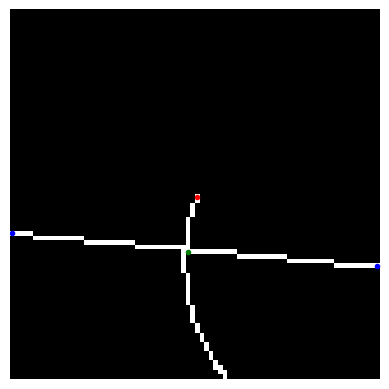

In [9]:
index = 1276

cy = check_points[0][index]
cx = check_points[1][index]
half_width = 40
cropped = False  # 标记是否重新裁剪过区域

while True:
    # 提取以候选点为中心的区域
    top = max(cy - half_width, 0)
    bottom = min(cy + half_width, thinned_bin.shape[0] - 1)
    left = max(cx - half_width, 0)
    right = min(cx + half_width, thinned_bin.shape[1] - 1)

    area = thinned_bin[top:bottom, left:right].copy()

    center_y = cy - top
    center_x = cx - left

    # 获取与中心连通的前景区域
    labels = cv2.connectedComponents(area, connectivity=8)[1]
    mask = (labels == labels[(center_y, center_x)]).astype(np.uint8)

    # 检测交叉点（通过局部卷积）
    conv_local = cv2.filter2D(mask, -1, kernel, borderType=cv2.BORDER_CONSTANT)
    cross_points = np.where(conv_local >= 13)

    filtered_cross_points = []
    for y, x in zip(cross_points[0], cross_points[1]):
        if y == 0 or y == mask.shape[0] - 1 or x == 0 or x == mask.shape[1] - 1:
            continue  # 去除边界
        Ap = get_Ap(mask, y, x)
        if Ap >= 3:
            filtered_cross_points.append((y, x))

    conv_local = cv2.filter2D(mask, -1, np.array([[1, 1], [1, 1]]), borderType=cv2.BORDER_CONSTANT)
    cross_points = np.where(conv_local == 4)
    for y, x in zip(cross_points[0], cross_points[1]):
        filtered_cross_points.append((y, x))

    if len(filtered_cross_points) == 0:
        break  # 无交叉点，跳过该点

    # 排序交叉点到中心的曼哈顿距离
    distances = [np.abs(y - center_y) + np.abs(x - center_x) for y, x in filtered_cross_points]
    sorted_indices = np.argsort(distances)

    # 多交叉点时，重新裁剪区域，使次近点落在边缘
    if len(filtered_cross_points) > 1 and not cropped:
        h1 = max(np.abs(filtered_cross_points[sorted_indices[0]][1] - center_x),
                    np.abs(filtered_cross_points[sorted_indices[0]][0] - center_y))
        h2 = max(np.abs(filtered_cross_points[sorted_indices[1]][1] - center_x),
                    np.abs(filtered_cross_points[sorted_indices[1]][0] - center_y))
        half_width = max(h1 + 2, h2 + 1)
        print(half_width)
        cropped = True
        continue

    # 提取边缘点（与 mask 相交的四边）
    edge_mask = np.zeros_like(mask, dtype=np.uint8)
    edge_mask[0, :] = edge_mask[-1, :] = edge_mask[:, 0] = edge_mask[:, -1] = 1
    edge_points = edge_mask * mask

    edge_points_num, edge_points_labels = cv2.connectedComponents(edge_points, connectivity=8)
    edge_point = []
    for i in range(1, edge_points_num):
        y, x = np.where(edge_points_labels == i)
        if len(y) == 1:
            edge_point.append((y[0], x[0]))
        elif len(y) > 1:
            p1 = (y[0], x[0])
            p2 = (y[-1], x[-1])
            dist1 = np.abs(p1[0] - half_width) + np.abs(p1[1] - half_width)
            dist2 = np.abs(p2[0] - half_width) + np.abs(p2[1] - half_width)
            if dist1 > dist2:
                edge_point.append(p2)
            else:
                edge_point.append(p1)

    if len(edge_point) < 2:
        break

    # 若边缘过多，仅保留最远的一对
    if len(edge_point) > 2:
        max_dist = -1
        p1, p2 = None, None
        for i in range(len(edge_point)):
            for j in range(i + 1, len(edge_point)):
                d = np.linalg.norm(np.array(edge_point[i]) - np.array(edge_point[j]))
                if d > max_dist:
                    max_dist = d
                    p1, p2 = edge_point[i], edge_point[j]
        edge_point = [p1, p2]

    # 判断交叉点是否方向稳定
    cross_point = filtered_cross_points[sorted_indices[0]]
    center_point = (center_y, center_x)

    v0 = np.array(center_point) - np.array(cross_point)
    v1 = np.array(edge_point[0]) - np.array(cross_point)
    v2 = np.array(edge_point[1]) - np.array(cross_point)

    v0_norm = v0 / (np.linalg.norm(v0) + 1e-8)
    v1_norm = v1 / (np.linalg.norm(v1) + 1e-8)
    v2_norm = v2 / (np.linalg.norm(v2) + 1e-8)

    cos01 = np.dot(v0_norm, v1_norm)
    cos02 = np.dot(v0_norm, v2_norm)
    cos12 = np.dot(v1_norm, v2_norm)

    # 判断向量v0是否在v1和v2之间（基于夹角余弦）
    if cos01 + cos02 > 0:
        print("T1")
    else:
        # 如果夹角大于120度，也认为是合法分支
        if cos12 < np.cos(np.deg2rad(120)):
            print("T2")
    break

plt.imshow(mask, cmap='gray')
plt.plot(center_x, center_y, 'ro', markersize=3)
plt.plot(cross_point[1], cross_point[0], 'go', markersize=3)
for point in edge_point:
    plt.plot(point[1], point[0], 'bo', markersize=3)
plt.axis('off')
plt.show() 

In [ ]:
fig.savefig(f'result.png', dpi=300, bbox_inches='tight')